## A recreation of Rodriguez-Ruiz et al.'s model for classifying depression using the depresjon dataset.

### An outline of the pre-processing tasks:

1) Extract all the activity data into a single data frame

2) Crop the data so that each participant has an equal number of activity readings

3) Segment the data into one hour intervals (Summing the data)

4) Split the data into day (8 - 20hrs), night (21 - 7hrs) and full day subsets

5) Remove any missing data

6) Perform a standardisation $z_i = \frac{x_i -\bar x}{s}$

In [91]:
# Import modules

import os
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import seaborn as sns
from datetime import date, timedelta
from matplotlib import pyplot as plt

In [92]:
# Petter's code for extracting all the data files and then combining them.

def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)

    # Final concat
    return df

In [93]:
df

,timestamp,date,activity,id,label,Hour,hour
0,2003-03-18 15:00:00,2003-03-18,60,control_1,0,15.0,15.0
1,2003-03-18 15:01:00,2003-03-18,0,control_1,0,15.0,15.0
2,2003-03-18 15:02:00,2003-03-18,264,control_1,0,15.0,15.0
3,2003-03-18 15:03:00,2003-03-18,662,control_1,0,15.0,15.0
4,2003-03-18 15:04:00,2003-03-18,293,control_1,0,15.0,15.0
...,...,...,...,...,...,...,...
1571701,2004-06-10 15:03:00,2004-06-10,0,condition_9,1,NaN,NaN
1571702,2004-06-10 15:04:00,2004-06-10,0,condition_9,1,NaN,NaN
1571703,2004-06-10 15:05:00,2004-06-10,449,condition_9,1,NaN,NaN
1571704,2004-06-10 15:06:00,2004-06-10,0,condition_9,1,NaN,NaN


In [94]:
# Extration of all the acitvity data into one data frame

df = extract_folder('../data/depresjon')
df.shape


(1571706, 5)

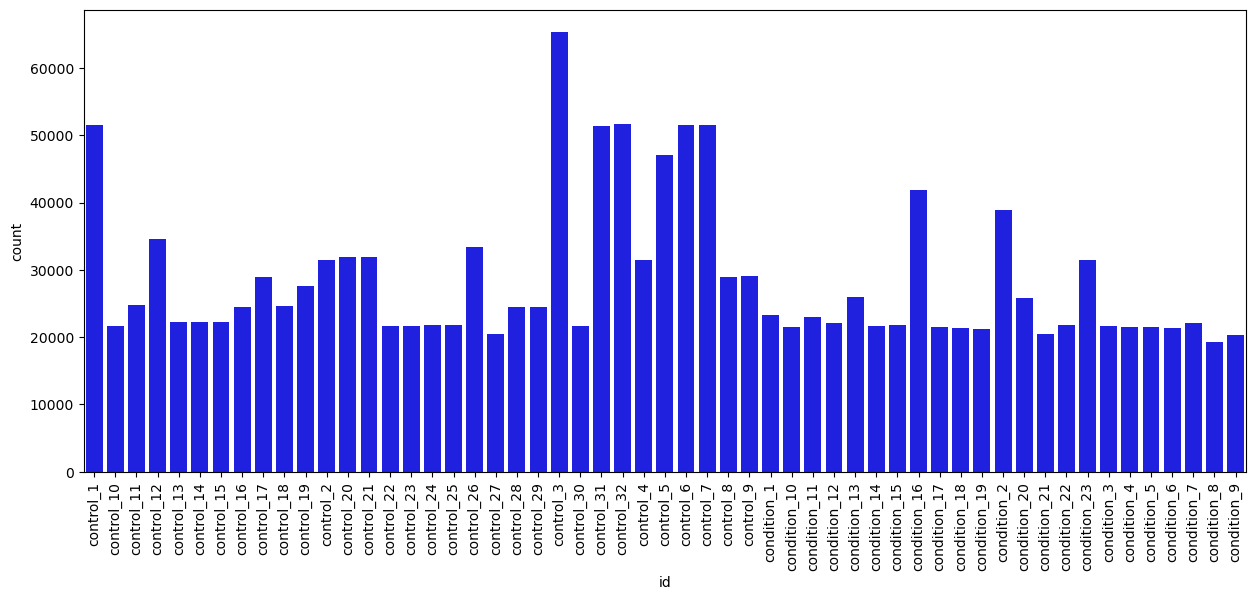

In [95]:
# Plot to show the number of recorded data values for each participant

plt.figure(figsize=(15, 6))

sns.countplot(data = df, x='id', color='blue')
plt.xticks(rotation=90)
plt.show()


In [96]:
# Function to find the minimum number of data values over all participants 

count = df['id'].value_counts()
count.min()

19299

In [97]:
# trimmed df is a dataset with only 19299 activity values for each participant

trimmed_df = df.groupby('id').head(19299)

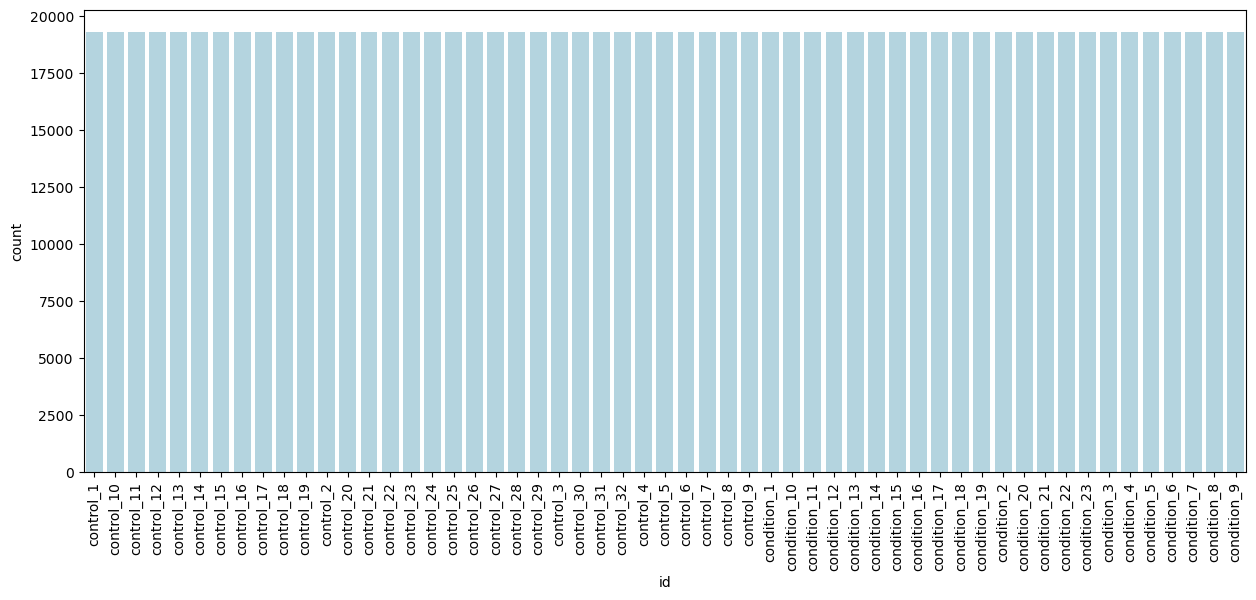

In [98]:
# Plot to check the number of recorded trimmed data values for each participant

plt.figure(figsize=(15, 6))

sns.countplot(data = trimmed_df, x='id', color='lightblue')
plt.xticks(rotation=90)
plt.show()

In [99]:
df['hour'] = trimmed_df['timestamp'].dt.hour
segmented_df = df.groupby(['date','hour','id','label'])['activity'].sum().reset_index()

segmented_df

,date,hour,id,label,activity
0,2002-05-24,11.0,condition_20,1,4359
1,2002-05-24,12.0,condition_20,1,7718
2,2002-05-24,13.0,condition_20,1,8124
3,2002-05-24,14.0,condition_20,1,4321
4,2002-05-24,15.0,condition_20,1,14982
...,...,...,...,...,...
17717,2006-02-12,18.0,control_30,0,26934
17718,2006-02-12,19.0,control_30,0,33631
17719,2006-02-12,20.0,control_30,0,10881
17720,2006-02-12,21.0,control_30,0,17866


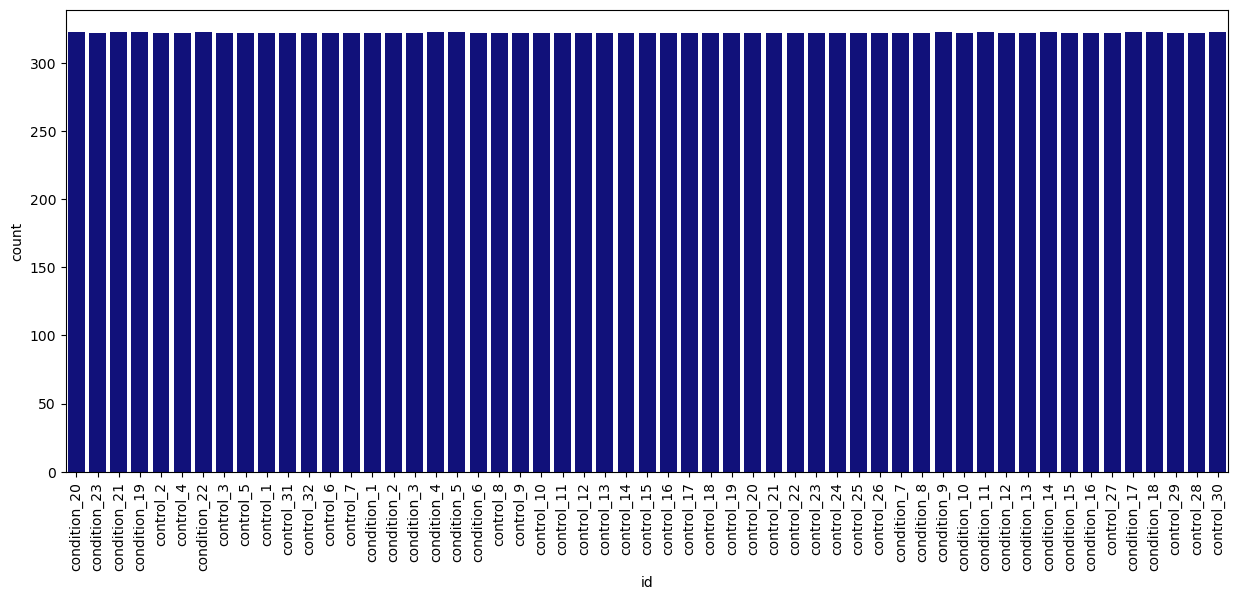

In [100]:
# Plot to check the number of recorded segmented data values for each participant

plt.figure(figsize=(15, 6))

sns.countplot(data = segmented_df, x='id', color='darkblue')
plt.xticks(rotation=90)
plt.show()

In [101]:
# check for null values

segmented_df.isnull().sum()

date        0
hour        0
id          0
label       0
activity    0
dtype: int64

In [102]:
# creation of the 3 datasets

fullday_df = segmented_df.copy()
day_df = segmented_df[(segmented_df['hour'] >= 8) & (segmented_df['hour'] <=20)]
night_df = segmented_df[(segmented_df['hour'] < 8) | (segmented_df['hour'] > 20)]

In [103]:
# Function to find the minimum number of data values for each subset 

print(day_df.shape)
print(night_df.shape)
print(fullday_df.shape)

(9794, 5)
(7928, 5)
(17722, 5)


In [104]:
# Check I haven't dropped any participants

No_Participants = len([segmented_df['id'].unique()][0])
print(No_Participants)

55


### Mistake or a misinterpretation in the article

As you can see from the above result I have created 17722 data values copying the same process set out in the article. My result is a much smaller value compared with the amount (26113) quoted in the article. Under further scrutiny the quoted 26113 could not be created from an even split of the 55 participants as it is not divisable, my conclusion is that the process outlined in the article is not consistent with the results. I will continue to recreate the rest of the article using the smaller datasets and revisit this issue at a later time.

In [105]:
def adding_standardised_column(dataframe):
    dataframe.copy()
    avg = dataframe['activity'].mean()
    sd = dataframe['activity'].std()
    dataframe['standardised_activity'] = (dataframe['activity']-avg)/sd
    dataframe.drop('date', axis=1, inplace=True)
    dataframe.drop('hour', axis=1, inplace=True)
    dataframe.drop('activity', axis=1, inplace=True)
    return dataframe

adding_standardised_column(day_df)
adding_standardised_column(night_df)
adding_standardised_column(fullday_df)

C:\Users\44778\AppData\Local\Temp\ipykernel_40768\217515689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['standardised_activity'] = (dataframe['activity']-avg)/sd
C:\Users\44778\AppData\Local\Temp\ipykernel_40768\217515689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop('date', axis=1, inplace=True)
C:\Users\44778\AppData\Local\Temp\ipykernel_40768\217515689.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,id,label,standardised_activity
0,condition_20,1,-0.649837
1,condition_20,1,-0.434285
2,condition_20,1,-0.408231
3,condition_20,1,-0.652276
4,condition_20,1,0.031859
...,...,...,...
17717,control_30,0,0.798840
17718,control_30,0,1.228598
17719,control_30,0,-0.231309
17720,control_30,0,0.216931


In [106]:
# check output of the function

print(fullday_df.head())
print(fullday_df.shape)
print()
print(day_df.head())
print(fullday_df.shape)
print()
print(night_df.head())
print(fullday_df.shape)
print()

             id  label  standardised_activity
0  condition_20      1              -0.649837
1  condition_20      1              -0.434285
2  condition_20      1              -0.408231
3  condition_20      1              -0.652276
4  condition_20      1               0.031859
(17722, 3)

             id  label  standardised_activity
0  condition_20      1              -0.977469
1  condition_20      1              -0.771144
2  condition_20      1              -0.746206
3  condition_20      1              -0.979804
4  condition_20      1              -0.324955
(17722, 3)

              id  label  standardised_activity
10  condition_20      1               0.828385
11  condition_20      1              -0.640480
12  condition_20      1              -0.184768
13  condition_20      1              -0.661674
14  condition_20      1              -0.656713
(17722, 3)



### An outline of the feature extraction tasks

1)  Then the following features are extracted before the data is transformed (time-domain):
        
    - Mean
    - Median
    - SD
    - Variance
    - Kurtosis
    - Coefficeint of Variance $\sigma/\mu$
    - IQR
    - Min
    - Max
    - Trimmed Mean (The amount trimmed is not specified so I will use the middle 50% of data)
    
2) Fast fourier transform is applied to create (frequency domain data).
    
3) The same features are extracted as above but also included are:

    - Spectral Density
    - Entropy
    - Skewness
    - Spectral flatness

### An outline of the modelling and evaluation tasks

1)  Create the a training datasets for the day subset using the following 9 best features based on time-doamin(T) or frequecy domain (F) data:

- kurtosis (T)
- mean (T)
- median (T)
- min (T)
- trim mean (T)
- median (F)
- SD (F)
- Coefficient of variance (F)
- Spectral Flatness (F)

2)  Create the a training datasets for the night subset using the following 9 best features based on time-doamin(T) or frequecy domain (F) data:

- kurtosis (T)
- median (T)
- IQR (T)
- min (T)
- max (T)
- median (F)
- SD (F)
- Coefficient of variance(F)
- Spectral Flatness (F)


3)  Create the a training datasets for the fullday subset using the following 9 best features based on time-doamin(T) or frequecy domain (F) data:

- kurtosis(T)
- median(T)
- coefficient of variance (T)
- min (T)
- trim mean(T)
- median (F)
- SD (F)
- Coefficient of variance(F)
- Spectral Flatness (F)

4) Evaluate the effectiveness using the following measures:

- True Positive
- True negative
- false positive
- false negative
- sensitiveity
- specificity
- predictive value (PPV)
- negative predicted value
- accuracy

In [ ]:
# Create two new data frames for night and day data
day_data=data[data['time_of_day'] == "day"]
night_data=data[data['time_of_day'] == "night"]

NameError: name 'data' is not defined